Instructions: 

1. Make sure that the ``__best_f1.weights`` that model.py's ``interactive_version()`` will load already exists, that model.py has ``PRESENT=True``, and that the values are correct in that file. 

2. Then run everything, and the demo is at the bottom

3. The picture in the demo is the estimated probability of insult if the comment were to end right after that letter

## Load the baseline model

In [71]:
# The baseline model
import utils
from baseline import bigramsPhi
print("\n\nLOGISTIC MAXENT CLASSIFIER - UNI+BIGRAMS")
baseline_model_and_vectorizer = []
utils.experiment(train_reader=utils.trainPlusDevReader, \
                 assess_reader=utils.testReader, \
                 phi=bigramsPhi, \
                 return_model=baseline_model_and_vectorizer)



LOGISTIC MAXENT CLASSIFIER - UNI+BIGRAMS
Percent insults: 0.469
             precision    recall  f1-score   support

          0      0.641     0.937     0.761      1019
          1      0.851     0.406     0.550       901

avg / total      0.740     0.688     0.662      1920

Accuracy: 0.688
AUC:      0.751662366207
AUC:      0.751662366207


0.65561095009131665

In [72]:
baseline_model = baseline_model_and_vectorizer[0]
baseline_vectorizer  = baseline_model_and_vectorizer[1]
baseline_vectorizer

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

## Load the final model

In [73]:
import model
from tensorflow.python.framework import ops
ops.reset_default_graph()
# from model import interactive_version
model_predict, m, sess = model.interactive_version()


418578.0 total chars with 97 uniques
---------LOADED TRAIN------------
Total comments in the dataset: 4863
Max comment length: 4863
Percent under threshold ( 200 ): 100.0
Percent insults: 28.0896565906
--------------------------------
---------LOADED DEV------------
Total comments in the dataset: 1920
Max comment length: 1920
Percent under threshold ( 200 ): 100.0
Percent insults: 46.9270833333
--------------------------------
---------LOADED TEST------------
Total comments in the dataset: 1920
Max comment length: 1920
Percent under threshold ( 200 ): 100.0
Percent insults: 46.9270833333
--------------------------------
Loaded data
Added placeholders: 300 hidden dims | 1 layers
Added character embeddings:
Setting up model
Added model: lstm__h_300__lr_0.002__l2_3e-05__dp_0.7__cdp_0.7__bs_1__embed_300__bd_False
Added prediction
	L2 regularization on RNN/MultiRNNCell/Cell0/LSTMCell/W_0:0
Added loss op
Added train op


In [111]:
import numpy as np
def predict(comment):
    probs_over_time = []
    pred = []
    print comment
    for i in range(len(comment)):
        encoded = [m.vocab.encode(m.vocab.start)] + \
                    [m.vocab.encode(char) for char in comment[:i+1]] +  \
                    [m.vocab.encode(m.vocab.end)]
        seq_length = len(encoded)
        encoded = np.array(encoded)
        encoded = np.pad(encoded, (0, utils.MAX_COMMENT_LENGTH - len(encoded)), mode='constant', constant_values=0)
        encoded = np.reshape(encoded, (1, -1)).T
        feed = {m.input_placeholder: encoded,
                m.labels_placeholder: np.zeros([1,2]),
                m.sequence_lengths: [seq_length],
                m.dropout_placeholder: 1.0}
        prob, pred, _ = sess.run([m.probs, m.prediction, m.probs_over_time], feed_dict=feed)
        probs_over_time.append(prob)
    return probs_over_time[-1], pred, probs_over_time

In [113]:
a, b, c = predict("1234")
d, e, f = predict("    ")
print np.array(c) - np.array(f)


1234
    
[[-0.43129283]
 [-0.51878196]
 [-0.48994163]
 [-0.46043453]]


## Set up interactive features

In [76]:
from ipywidgets import widgets, interact
from IPython.display import display, clear_output, Image

# Create text widget for input
input_text = widgets.Text()

In [77]:
%matplotlib inline
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure("main", figsize=(10,4))

In [78]:
def newDraw(data):
    nothing = plt.clf()
    nothing = plt.figure("main", figsize=(20,4))
    ax = plt.gca()
    sns.heatmap(data, ax=ax, cmap="YlGnBu",
                        cbar_kws={"orientation": "horizontal"},
                        linewidths=.5, yticklabels=False,
                        vmin=0, vmax=1)

    zed = [tick.label.set_fontsize(20) for tick in ax.xaxis.get_major_ticks()]
    zed = [tick.label.set_color('darkred') for tick in ax.xaxis.get_major_ticks()]
    ax.set_xticklabels(list(input_text.value))
    ax.set_aspect(1)
    ax.set_title("Probability of insult at each time step")
    plt.savefig("../analysis/test_comment.png")
    clear_output()


In [79]:
img = widgets.Image()
# with open("../analysis/test_comment.png", "rb") as imageFile:
#   f = imageFile.read()
    
# img.value = bytes(f)

def cleanComment(comment):
  ''' Returns a cleaned version of the comment '''
  comment = comment.replace('\\\\n', ' ')
  comment = comment.replace('\\xc2', ' ')
  comment = comment.replace('\\xa0', ' ')
  comment = comment.replace('\\n', ' ')
  comment = " ".join(utils.tkzr.tokenize(comment))
  comment = utils.t_prsr.parse(comment).html
  return comment

def baseline_comment_reader():
    yield cleanComment(input_text.value), 0

    
    
# Create text widget for output
output = widgets.HTML()

# Define function to bind value of the input to the output variable 
def bind_input_to_output(sender):
    assess = utils.buildDataset(
        baseline_comment_reader, 
        bigramsPhi, 
        lambda x: x, 
        vectorizer=baseline_vectorizer)
    result = baseline_model.predict_proba(assess['X'])[0,1]
    prob, pred, probs_over_time = predict(input_text.value)
    
    
    def getColor(val):
        return 'style="color:red"' if val > 0.5 else 'style="color:green"'
    
    
    results_str = "<h1> Probability of insult </h1>"
    baseline_str = '<h1 class="baseline"' + getColor(result) + '>' + "Bigrams: \t\t<br>" + str(result) + '</h1>'
    char_lstm_str = '<h1 class="char_lstm"' + getColor(prob[0]) + '>' + "Char LSTM: \t<br>" + str(prob[0]) + '</h1>'
    spacing = "<br><br>"
    output.value = results_str + baseline_str + char_lstm_str + spacing
    newDraw(np.reshape(probs_over_time[:len(input_text.value)], (1, -1)))
#     with open("../analysis/test_comment.png", "rb") as imageFile:
#       f = imageFile.read()
#     img.value = bytes(f)

# Tell the text input widget to call bind_input_to_output() on submit
input_text.on_submit(bind_input_to_output)

In [80]:
from IPython.core.display import HTML
HTML("<style> h2{text-align:center;} h1{text-align:center;} h1.baseline{width: 50%;float: left;font-family:'Courier New';}"
    +"h1.char_lstm{width: 50%;float: right;font-family:'Courier New';} </style>")

# Abusive Comment Detection
## Sasha Sax

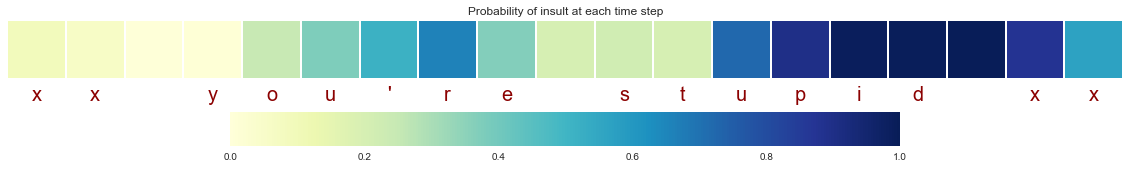

In [81]:
display(input_text)  # Type in a comment to see it evaluated:
display(output)

#    


#      

#     

#        

#      